# Applying GIRAFFE on in silico data

In this notebook, we aim to investigate the performance of GIRAFFE on two artificial datasets. These datasets are designed to be representative of the underlying biology, and show that GIRAFFE performs well under those assumptions. We will use PANDA [1], OTTER [2], and the motif as comparisons. 

## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
import matplotlib.pyplot as plt
import networkx as nx
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import numpy as np
from numpy.random import default_rng
import pandas as pd
import random
import scipy
from scipy import stats

In [35]:
from sklearn.tree import BaseDecisionTree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import numpy
import time
from operator import itemgetter
from multiprocessing import Pool


def compute_feature_importances(estimator):
    if isinstance(estimator, BaseDecisionTree):
        return estimator.tree_.compute_feature_importances(normalize=False)
    else:
        importances = [e.tree_.compute_feature_importances(normalize=False)
                       for e in estimator.estimators_]
        importances = array(importances)
        return sum(importances,axis=0) / len(estimator)
        


def get_link_list(VIM,gene_names=None,regulators='all',maxcount='all',file_name=None):
    
    """Gets the ranked list of (directed) regulatory links.
    
    Parameters
    ----------
    
    VIM: numpy array
        Array as returned by the function GENIE3(), in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. 
        
    gene_names: list of strings, optional
        List of length p, where p is the number of rows/columns in VIM, containing the names of the genes. The i-th item of gene_names must correspond to the i-th row/column of VIM. When the gene names are not provided, the i-th gene is named Gi.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names), and the returned list contains only edges directed from the candidate regulators. When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    maxcount: 'all' or positive integer, optional
        Writes only the first maxcount regulatory links of the ranked list. When maxcount is set to 'all', all the regulatory links are written.
        default: 'all'
        
    file_name: string, optional
        Writes the ranked list of regulatory links to the file file_name.
        default: None
        
        
    
    Returns
    -------
    
    The list of regulatory links, ordered according to the edge score. Auto-regulations do not appear in the list. Regulatory links with a score equal to zero are randomly permuted. In the ranked list of edges, each line has format:
        
        regulator   target gene     score of edge
    """
    
    # Check input arguments      
    if not isinstance(VIM,ndarray):
        raise ValueError('VIM must be a square array')
    elif VIM.shape[0] != VIM.shape[1]:
        raise ValueError('VIM must be a square array')
        
    ngenes = VIM.shape[0]
        
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expression data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('The genes must contain at least one candidate regulator')
        
    if maxcount != 'all' and not isinstance(maxcount,int):
        raise ValueError('input argument maxcount must be "all" or a positive integer')
        
    if file_name is not None and not isinstance(file_name,str):
        raise ValueError('input argument file_name must be a string')
    
    

    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = range(ngenes)
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]
    
    # Get the non-ranked list of regulatory links
    vInter = [(i,j,score) for (i,j),score in ndenumerate(VIM) if i in input_idx and i!=j]
    
    # Rank the list according to the weights of the edges        
    vInter_sort = sorted(vInter,key=itemgetter(2),reverse=True)
    nInter = len(vInter_sort)
    
    # Random permutation of edges with score equal to 0
    flag = 1
    i = 0
    while flag and i < nInter:
        (TF_idx,target_idx,score) = vInter_sort[i]
        if score == 0:
            flag = 0
        else:
            i += 1
            
    if not flag:
        items_perm = vInter_sort[i:]
        items_perm = random.permutation(items_perm)
        vInter_sort[i:] = items_perm
        
    # Write the ranked list of edges
    nToWrite = nInter
    if isinstance(maxcount,int) and maxcount >= 0 and maxcount < nInter:
        nToWrite = maxcount
        
    if file_name:
    
        outfile = open(file_name,'w')
    
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('%s\t%s\t%.6f\n' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                outfile.write('G%d\tG%d\t%.6f\n' % (TF_idx+1,target_idx+1,score))
            
        
        outfile.close()
        
    else:
        
        if gene_names is not None:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('%s\t%s\t%.6f' % (gene_names[TF_idx],gene_names[target_idx],score))
        else:
            for i in range(nToWrite):
                (TF_idx,target_idx,score) = vInter_sort[i]
                TF_idx = int(TF_idx)
                target_idx = int(target_idx)
                print('G%d\tG%d\t%.6f' % (TF_idx+1,target_idx+1,score))
                
                
                



def GENIE3(expr_data,gene_names=None,regulators='all',tree_method='RF',K='sqrt',ntrees=1000,nthreads=1):
    
    '''Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    expr_data: numpy array
        Array containing gene expression values. Each row corresponds to a condition and each column corresponds to a gene.
        
    gene_names: list of strings, optional
        List of length p, where p is the number of columns in expr_data, containing the names of the genes. The i-th item of gene_names must correspond to the i-th column of expr_data.
        default: None
        
    regulators: list of strings, optional
        List containing the names of the candidate regulators. When a list of regulators is provided, the names of all the genes must be provided (in gene_names). When regulators is set to 'all', any gene can be a candidate regulator.
        default: 'all'
        
    tree-method: 'RF' or 'ET', optional
        Specifies which tree-based procedure is used: either Random Forest ('RF') or Extra-Trees ('ET')
        default: 'RF'
        
    K: 'sqrt', 'all' or a positive integer, optional
        Specifies the number of selected attributes at each node of one tree: either the square root of the number of candidate regulators ('sqrt'), the total number of candidate regulators ('all'), or any positive integer.
        default: 'sqrt'
         
    ntrees: positive integer, optional
        Specifies the number of trees grown in an ensemble.
        default: 1000
    
    nthreads: positive integer, optional
        Number of threads used for parallel computing
        default: 1
        
        
    Returns
    -------
    An array in which the element (i,j) is the score of the edge directed from the i-th gene to the j-th gene. All diagonal elements are set to zero (auto-regulations are not considered). When a list of candidate regulators is provided, the scores of all the edges directed from a gene that is not a candidate regulator are set to zero.
        
    '''
    
    time_start = time.time()
    
    # Check input arguments
    if not isinstance(expr_data,ndarray):
        raise ValueError('expr_data must be an array in which each row corresponds to a condition/sample and each column corresponds to a gene')
        
    ngenes = expr_data.shape[1]
    
    if gene_names is not None:
        if not isinstance(gene_names,(list,tuple)):
            raise ValueError('input argument gene_names must be a list of gene names')
        elif len(gene_names) != ngenes:
            raise ValueError('input argument gene_names must be a list of length p, where p is the number of columns/genes in the expr_data')
        
    if regulators != 'all':
        if not isinstance(regulators,(list,tuple)):
            raise ValueError('input argument regulators must be a list of gene names')

        if gene_names is None:
            raise ValueError('the gene names must be specified (in input argument gene_names)')
        else:
            sIntersection = set(gene_names).intersection(set(regulators))
            if not sIntersection:
                raise ValueError('the genes must contain at least one candidate regulator')        
        
    if tree_method != 'RF' and tree_method != 'ET':
        raise ValueError('input argument tree_method must be "RF" (Random Forests) or "ET" (Extra-Trees)')
        
    if K != 'sqrt' and K != 'all' and not isinstance(K,int): 
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
        
    if isinstance(K,int) and K <= 0:
        raise ValueError('input argument K must be "sqrt", "all" or a stricly positive integer')
    
    if not isinstance(ntrees,int):
        raise ValueError('input argument ntrees must be a stricly positive integer')
    elif ntrees <= 0:
        raise ValueError('input argument ntrees must be a stricly positive integer')
        
    if not isinstance(nthreads,int):
        raise ValueError('input argument nthreads must be a stricly positive integer')
    elif nthreads <= 0:
        raise ValueError('input argument nthreads must be a stricly positive integer')
        
        
    print('Tree method: ' + str(tree_method))
    print('K: ' + str(K))
    print('Number of trees: ' + str(ntrees))
    print('\n')
        
    
    # Get the indices of the candidate regulators
    if regulators == 'all':
        input_idx = list(range(ngenes))
    else:
        input_idx = [i for i, gene in enumerate(gene_names) if gene in regulators]

    
    # Learn an ensemble of trees for each target gene, and compute scores for candidate regulators
    VIM = zeros((ngenes,ngenes))
    
    if nthreads > 1:
        print('running jobs on %d threads' % nthreads)

        input_data = list()
        for i in range(ngenes):
            input_data.append( [expr_data,i,input_idx,tree_method,K,ntrees] )

        pool = Pool(nthreads)
        alloutput = pool.map(wr_GENIE3_single, input_data)
    
        for (i,vi) in alloutput:
            VIM[i,:] = vi

    else:
        print('running single threaded jobs')
        for i in range(ngenes):
            print('Gene %d/%d...' % (i+1,ngenes))
            
            vi = GENIE3_single(expr_data,i,input_idx,tree_method,K,ntrees)
            VIM[i,:] = vi

   
    VIM = transpose(VIM)
 
    time_end = time.time()
    print("Elapsed time: %.2f seconds" % (time_end - time_start))

    return VIM
    
    
    
def wr_GENIE3_single(args):
    return([args[1], GENIE3_single(args[0], args[1], args[2], args[3], args[4], args[5])])
    


def GENIE3_single(expr_data,output_idx,input_idx,tree_method,K,ntrees):
    
    ngenes = expr_data.shape[1]
    
    # Expression of target gene
    output = expr_data[:,output_idx]
    
    # Normalize output data
    #output = output / std(output)
    
    # Remove target gene from candidate regulators
    input_idx = input_idx[:]
    if output_idx in input_idx:
        input_idx.remove(output_idx)

    expr_data_input = expr_data[:,input_idx]
    
    # Parameter K of the tree-based method
    if (K == 'all') or (isinstance(K,int) and K >= len(input_idx)):
        max_features = "auto"
    else:
        max_features = K
    
    if tree_method == 'RF':
        treeEstimator = RandomForestRegressor(n_estimators=ntrees,max_features=max_features)
    elif tree_method == 'ET':
        treeEstimator = ExtraTreesRegressor(n_estimators=ntrees,max_features=max_features)

    # Learn ensemble of trees
    treeEstimator.fit(expr_data_input,output)
    
    # Compute importance scores
    feature_importances = compute_feature_importances(treeEstimator)
    vi = zeros(ngenes)
    vi[input_idx] = feature_importances
       
    return vi


In [36]:
tf = 100
g = 500
names = [str(i) for i in range(600)]
ppi = generate_ppi(tf)
TFA = generate_tfa(ppi, 50)
R = generate_regulation(g, tf, ppi)
gene_expression = compute_expression(R, TFA)
motif = generate_motif(R, 0.2)
a = GENIE3(np.vstack([gene_expression, TFA]).T)

Tree method: RF
K: sqrt
Number of trees: 1000


running single threaded jobs
Gene 1/600...
Gene 2/600...
Gene 3/600...
Gene 4/600...
Gene 5/600...
Gene 6/600...
Gene 7/600...
Gene 8/600...
Gene 9/600...
Gene 10/600...
Gene 11/600...
Gene 12/600...
Gene 13/600...
Gene 14/600...
Gene 15/600...
Gene 16/600...
Gene 17/600...
Gene 18/600...
Gene 19/600...
Gene 20/600...
Gene 21/600...
Gene 22/600...
Gene 23/600...
Gene 24/600...
Gene 25/600...
Gene 26/600...
Gene 27/600...
Gene 28/600...
Gene 29/600...
Gene 30/600...
Gene 31/600...
Gene 32/600...
Gene 33/600...
Gene 34/600...
Gene 35/600...
Gene 36/600...
Gene 37/600...
Gene 38/600...
Gene 39/600...
Gene 40/600...
Gene 41/600...
Gene 42/600...
Gene 43/600...
Gene 44/600...
Gene 45/600...
Gene 46/600...
Gene 47/600...
Gene 48/600...
Gene 49/600...
Gene 50/600...
Gene 51/600...
Gene 52/600...
Gene 53/600...
Gene 54/600...
Gene 55/600...
Gene 56/600...
Gene 57/600...
Gene 58/600...
Gene 59/600...
Gene 60/600...
Gene 61/600...
Gene 62/600...
Ge

/tmp/ipykernel_98787/3968752656.py:308: RuntimeWarning: divide by zero encountered in true_divide
  output = output / std(output)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

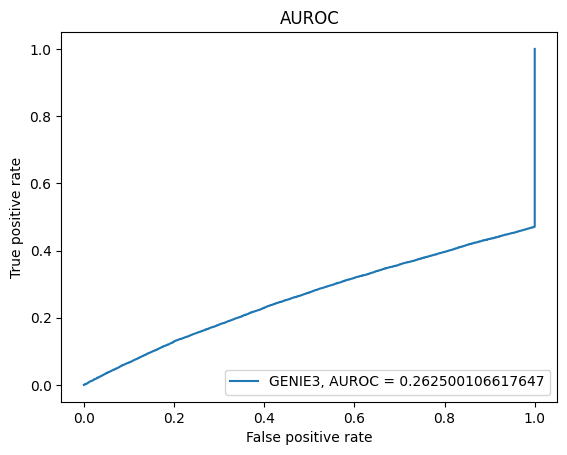

[[1.46974344e-14 5.43740645e-04 7.08630222e-04 ... 2.80095264e-12
  4.53743401e-04 2.56850942e-04]
 [1.46974344e-14 2.39735696e-03 1.85044251e-04 ... 1.10128894e-12
  8.59465416e-04 3.33519739e-04]
 [1.50612323e-13 6.36911571e-04 9.76123561e-04 ... 3.51574272e-13
  1.34299277e-04 6.06757362e-04]
 ...
 [1.16415322e-15 9.30891350e-04 3.69046658e-04 ... 2.35158950e-13
  1.73537901e-04 1.10220615e-03]
 [7.13043846e-15 3.18127474e-04 4.99931217e-04 ... 2.24914402e-12
  3.32878113e-04 7.84333315e-04]
 [2.57568900e-14 2.04667415e-04 6.80808042e-04 ... 9.15024430e-13
  1.86164721e-04 1.43794736e-03]]


In [34]:
giraffe.plot_auroc(R, [a[0:500, 500:]], ["GENIE3"])
print(a[0:500, 500:])

## 2. Recovering ground-truth from model satisfying our assumptions

In TODO we present GIRAFFE and its underlying assumptions. Here we create a toy dataset to show that GIRAFFE performs well under those assumptions. We need to generate the true regulation matrix R, the transcription factor activity matrix TFA, the PPI network, the gene expression, and the motif. The number of genes, transcription factors, and samples are picked to be coherent with the typical biological setting. 

In [2]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

We start with the PPI network, an undirected graph where the degree of each edge is sampled according to the distribution observed on real data. 

In [3]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('data/sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

We assume that transcription factors form a protein complex if they form a clique in the PPI. The next piece of code return the cliques, i.e. the protein complexes, for every transcription factor. 

In [4]:
def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

At this point we are ready to generate the TFA matrix. For each protein complex we generate its activity. The row corresponding to a given transcription factor is the sum of the quantity of its protein complexes.If a transcription factor is not part of a protein complex, we assume that it regulates genes independently from the others. 

In [5]:
def generate_tfa(ppi, n):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(0, 10, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(0, 10, n)
            
    return TFA #  Generated matrix

The mechanism to generate the true regulation matrix (which serves as ground-truth to estimate the performance) is similar: each protein complex (i.e. each clique in the PPI) has a sparse regulation vector describing its relationship with the target genes. Hence, for for each column in R, we sum the generated regulation vectors for each protein complex the transcription factor belongs to. If a transcription factor is not part of any complex, it can still regulate genes independently. 

In [15]:
def generate_regulation(g, tf, ppi) :
    sparsity = 0.5
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

We generate a binary motif as follows. First, we map each non-zero entry of R to one, resulting in a binary matrix. Then we we flip a certain number of entries, such that a zero (i.e. no regulation) becomes a one (i.e. regulation) and viceversa. The ratio of flipped bits is passed as the parameter shuffle to the function. 

In [7]:
def generate_motif(R, shuffle = 0.2):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * shuffle)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    motif = motif / np.sqrt(np.trace(motif.T @ motif))
    return motif

The expression matrix is generated as the product of the ground-truth matrices R and TFA. This is coherent with our underlying assumption that gene expression can be factorized as this product. 

In [8]:
def compute_expression(R, TFA) :
    return R.dot(np.abs(TFA)) 

Now we have all the required data for our simulation. We generated both the input to estimate the parameters of our model (gene expression, the PPI, and the motif), and the ground-truth to measure its performance(the regulation and transcription factor activity matrix). 

In [13]:
def simulation(n = 50, shuffling = 0.2):
    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA)
    motif = generate_motif(R, shuffling)
    
    #R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.000001).get_regulation()
    a = 0
    b = 0
    c = 0
    d = 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i, j] > 0:
                a += 1
                if R_giraffe[i, j] > 0:
                    b += 1
            if R[i, j] < 0:
                c += 1
                if R_giraffe[i, j] < 0:
                    d += 1
    print("TP = " + str(b))
    print("FP = " + str(a - b))
    print("TN = " + str(d))
    print("FN = " + str(c - d))
    print((b + d) / (a + c))
    R_otter = otter(motif.T, ppi, np.corrcoef(gene_expression), Iter = 200).T
    R_panda = giraffe.compute_panda_locally(gene_expression, motif, ppi)
    return giraffe.plot_auroc(R, [R_giraffe, R_otter, R_panda, motif], ["Our method", "OTTER", "PANDA", "Motif"], title = "AUROC, reliability of the motif = " + str(1 - shuffling))

TP = 14113
FP = 2826
TN = 2331
FN = 11980
0.526208
Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    124299.259041  124292.484127  124300.490204  124308.461303   
1    124334.846827  124315.298662  124324.481363  124319.438977   
2    124294.733645  124314.227675  124304.447981  124307.091697   
3    124357.122866  124367.979865  124342.907639  124356.655754   
4    124313.306198  124358.036731  124351.347299  124342.199824   
..             ...            ...            ...            ...   
495  124313.633826  124340.775749  124317.210017  124317.450322   
496  124313.677362  124334.286817  124339.560417  124318.315738   
497  124360.599301  124334.984007  124331.8

step: 101, hamming: 2118281.2228144133
step: 102, hamming: 2416445.744500815
step: 103, hamming: 2775411.8743412355
step: 104, hamming: 3200118.115077262
step: 105, hamming: 3691698.610124904
step: 106, hamming: 4244164.911773371
step: 107, hamming: 4839914.621555252
step: 108, hamming: 5444921.18532734
step: 109, hamming: 6006076.8887222605
step: 110, hamming: 6454965.978412859
step: 111, hamming: 6721775.791768199
step: 112, hamming: 6757381.500186266
step: 113, hamming: 6552653.267577399
step: 114, hamming: 6141929.265745413
step: 115, hamming: 5588289.450568239
step: 116, hamming: 4961376.70559163
step: 117, hamming: 4320345.594999897
step: 118, hamming: 3706708.666176184
step: 119, hamming: 3144832.290705822
step: 120, hamming: 2645861.857045208
step: 121, hamming: 2212145.5880772206
step: 122, hamming: 1840834.7097010622
step: 123, hamming: 1526402.9422791463
step: 124, hamming: 1262248.641003078
step: 125, hamming: 1041632.6762409618
step: 126, hamming: 858186.8318664207
step: 1

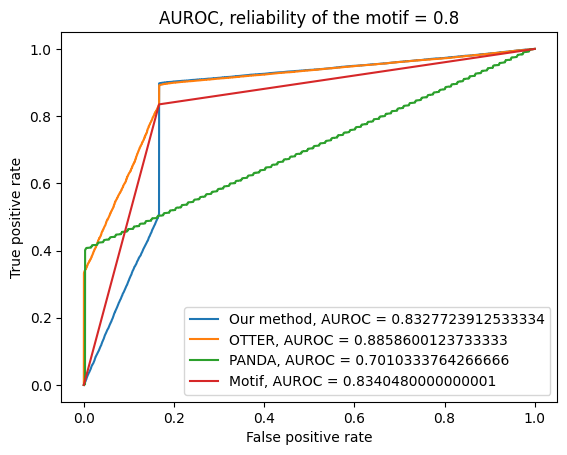

[0.8327723912533334,
 0.8858600123733333,
 0.7010333764266666,
 0.8340480000000001]

In [16]:
simulation()

TP = 12229
FP = 108
TN = 32
FN = 5756
0.6764689655172413
Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4605.854383  4606.087201  4605.332291  4601.400339  4608.555130   
1    4600.122445  4603.789725  4611.279477  4611.513033  4599.801237   
2    4597.815729  4588.854368  4600.249163  4608.315582  4591.258966   
3    4611.728330  4610.366159  4614.272747  4615.109566  4614.566270   
4    4590.989790  4593.807901  4593.679750  4591.733654  4601.291727   
..           ...          ...          ...          ...          ...   
495  4612.427792  4618.058966  4614.646834  4628.627636  4616.415232   
496  4629.473319  4606.437997  4618.146604  4626.389834  4624.93

step: 114, hamming: 407444.7810146045
step: 115, hamming: 333696.58813925117
step: 116, hamming: 273280.2440084756
step: 117, hamming: 223791.2417510145
step: 118, hamming: 183256.89361930828
step: 119, hamming: 150059.40039259216
step: 120, hamming: 122872.41835608105
step: 121, hamming: 100608.82846185387
step: 122, hamming: 82377.77072599786
step: 123, hamming: 67449.33603560389
step: 124, hamming: 55225.569453448785
step: 125, hamming: 45216.669017012864
step: 126, hamming: 37021.46068536399
step: 127, hamming: 30311.38590462592
step: 128, hamming: 24817.37353277102
step: 129, hamming: 20319.080103575994
step: 130, hamming: 16636.072878212697
step: 131, hamming: 13620.605443633753
step: 132, hamming: 11151.699663593949
step: 133, hamming: 9130.298028704834
step: 134, hamming: 7475.293203726345
step: 135, hamming: 6120.276165122135
step: 136, hamming: 5010.873218151274
step: 137, hamming: 4102.565267514687
step: 138, hamming: 3358.9020209667424
step: 139, hamming: 2750.039781892339


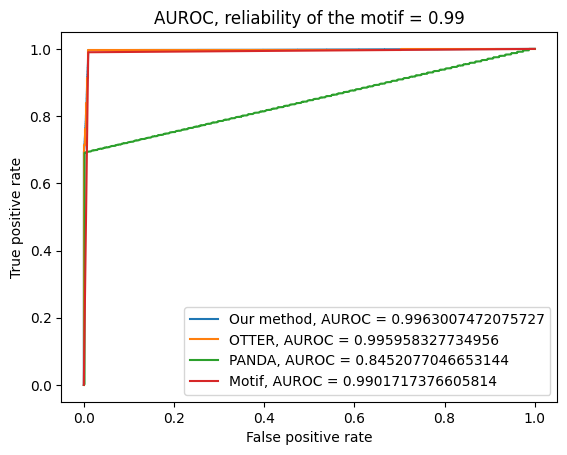

TP = 11936
FP = 401
TN = 318
FN = 5470
0.6760827586206897
Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.04 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4587.740204  4605.665512  4605.990800  4609.334924  4599.110688   
1    4609.520089  4622.922044  4615.071067  4613.087191  4607.762248   
2    4612.529617  4612.635659  4622.283384  4617.227599  4610.867031   
3    4590.103649  4595.990228  4588.687740  4593.934358  4598.790314   
4    4601.930591  4601.616672  4610.427846  4604.631243  4604.539303   
..           ...          ...          ...          ...          ...   
495  4594.167046  4586.433267  4591.416874  4593.749286  4595.534333   
496  4611.748934  4614.258006  4616.787618  4610.629044  4614.9

step: 114, hamming: 12429.095966305304
step: 115, hamming: 10181.139149751672
step: 116, hamming: 8338.977465428672
step: 117, hamming: 6829.616688767152
step: 118, hamming: 5593.106298047831
step: 119, hamming: 4580.237580608162
step: 120, hamming: 3750.6382404698047
step: 121, hamming: 3071.198550223506
step: 122, hamming: 2514.7733459509864
step: 123, hamming: 2059.113267042823
step: 124, hamming: 1685.9855486040353
step: 125, hamming: 1380.4514569391995
step: 126, hamming: 1130.2728681942322
step: 127, hamming: 925.4251648038028
step: 128, hamming: 757.6976428926959
step: 129, hamming: 620.36578509045
step: 130, hamming: 507.9225924843725
step: 131, hamming: 415.85836700295863
step: 132, hamming: 340.48024566682705
step: 133, hamming: 278.76435363475446
step: 134, hamming: 228.23467706499304
step: 135, hamming: 186.86384372087753
step: 136, hamming: 152.99186272023863
step: 137, hamming: 125.25956915990776
step: 138, hamming: 102.55412180902952
step: 139, hamming: 83.9643691748469


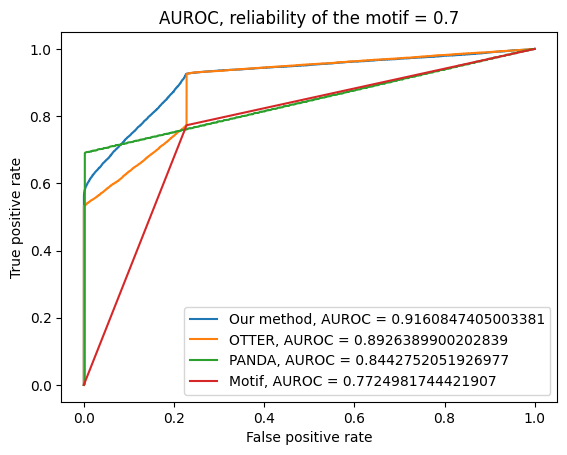

TP = 11824
FP = 513
TN = 375
FN = 5413
0.673048275862069
Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.04 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4597.616025  4597.204940  4592.943531  4603.670818  4590.982737   
1    4618.741562  4613.599314  4623.799231  4628.337670  4611.618135   
2    4610.229107  4606.879039  4597.094481  4608.751848  4609.014252   
3    4619.556133  4619.258695  4612.419221  4613.342831  4616.818963   
4    4612.989337  4621.634759  4617.496879  4611.243860  4612.163076   
..           ...          ...          ...          ...          ...   
495  4593.768995  4595.451829  4596.426986  4611.169413  4594.915795   
496  4611.278091  4620.229155  4617.902035  4613.494554  4610.73

step: 111, hamming: 0.005732962299120438
step: 112, hamming: 0.004693847724725929
step: 113, hamming: 0.003843067604533542
step: 114, hamming: 0.003146489294438186
step: 115, hamming: 0.0025761656077937806
step: 116, hamming: 0.0021092140493236947
step: 117, hamming: 0.0017268990667677136
step: 118, hamming: 0.0014138805937841243
step: 119, hamming: 0.00115759873579134
step: 120, hamming: 0.0009477699429455388
Running panda took: 2.91 seconds!
Saving PANDA network to tmp/panda_res.txt ...
                    Use old_compatible=False to save the panda results with correct column naming
  Elapsed time: 0.68 sec.


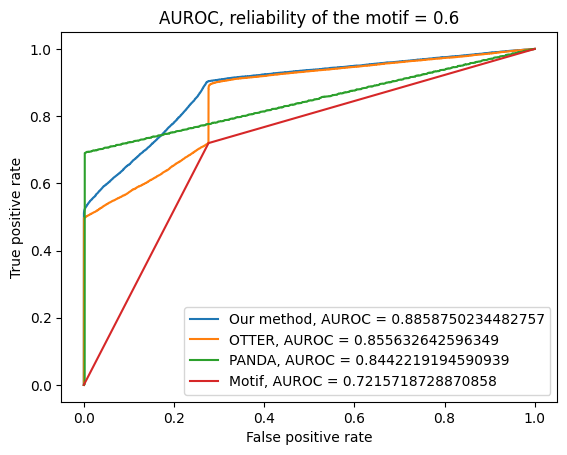

TP = 11754
FP = 583
TN = 416
FN = 5372
0.671448275862069
Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4603.940619  4600.208398  4606.457047  4605.508983  4599.781209   
1    4603.419566  4608.383529  4595.570175  4594.518263  4597.263172   
2    4608.561079  4618.119930  4600.662902  4609.936242  4607.712494   
3    4606.308048  4598.585410  4601.722779  4594.287446  4613.526397   
4    4592.104113  4600.634590  4604.881398  4596.516377  4597.052567   
..           ...          ...          ...          ...          ...   
495  4608.548165  4612.635879  4615.431956  4615.364127  4614.536500   
496  4614.984849  4616.356306  4616.304282  4629.997090  4610.31

step: 115, hamming: 0.0012667162343145465
step: 116, hamming: 0.0010371125860692554
step: 117, hamming: 0.0008491255836370401
Running panda took: 3.27 seconds!
Saving PANDA network to tmp/panda_res.txt ...
                    Use old_compatible=False to save the panda results with correct column naming
  Elapsed time: 0.70 sec.


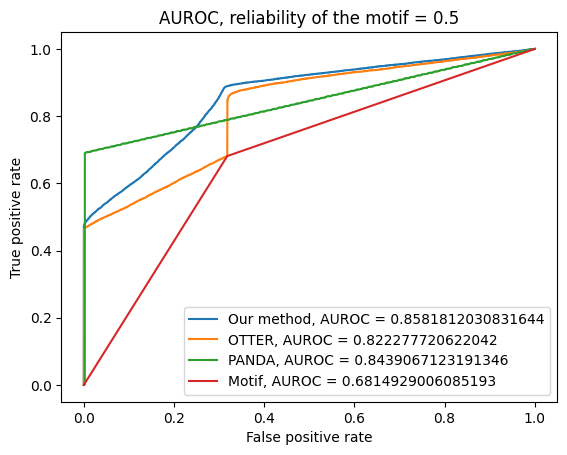

TP = 11612
FP = 725
TN = 479
FN = 5309
0.6670896551724138
Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4609.090237  4605.108148  4606.113939  4607.313365  4598.258742   
1    4612.714581  4612.960175  4609.675336  4612.154727  4614.450168   
2    4598.152570  4594.945885  4604.214630  4606.470691  4595.764656   
3    4607.787848  4609.772841  4613.661034  4612.775420  4614.358052   
4    4600.491879  4591.137906  4587.933660  4592.891134  4590.296763   
..           ...          ...          ...          ...          ...   
495  4603.030392  4609.852601  4594.968366  4609.407445  4604.662663   
496  4611.651209  4607.178493  4608.867848  4606.892183  4603.8

step: 116, hamming: 0.0012945139189049079
step: 117, hamming: 0.0010598706764379166
step: 118, hamming: 0.0008677577945122611
Running panda took: 3.70 seconds!
Saving PANDA network to tmp/panda_res.txt ...
                    Use old_compatible=False to save the panda results with correct column naming
  Elapsed time: 0.67 sec.


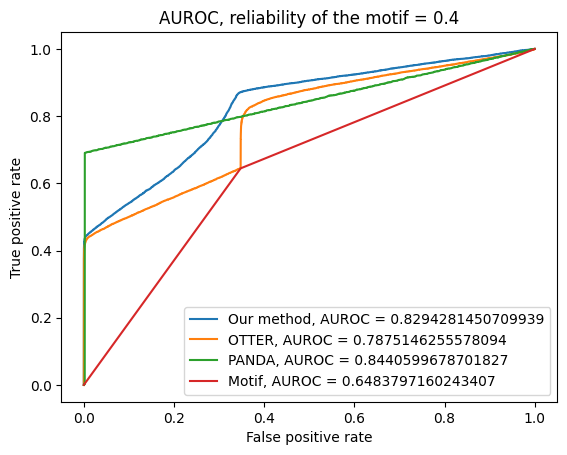

TP = 11571
FP = 766
TN = 507
FN = 5281
0.6663724137931034
Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4615.024821  4611.220246  4612.623934  4603.374921  4603.853491   
1    4599.452513  4596.592668  4592.096878  4597.787515  4593.329361   
2    4611.826320  4608.804223  4600.707027  4602.350908  4600.564223   
3    4593.325494  4593.352533  4583.933730  4586.501799  4591.076819   
4    4601.435235  4592.309506  4603.156905  4593.311902  4582.915733   
..           ...          ...          ...          ...          ...   
495  4629.491545  4617.954909  4617.520783  4626.181685  4614.614816   
496  4627.020142  4616.460015  4615.121543  4617.998288  4615.8

step: 115, hamming: 0.013478596429901561
step: 116, hamming: 0.011035621711994313
step: 117, hamming: 0.009035398983315351
step: 118, hamming: 0.00739769652745643
step: 119, hamming: 0.006056818295191844
step: 120, hamming: 0.004958971482709088
step: 121, hamming: 0.004060110519734161
step: 122, hamming: 0.0033241713519984186
step: 123, hamming: 0.002721625430719407
step: 124, hamming: 0.0022282955771872914
step: 125, hamming: 0.0018243863214564772
step: 126, hamming: 0.0014936898970170842
step: 127, hamming: 0.0012229360824871946
step: 128, hamming: 0.0010012598416266937
step: 129, hamming: 0.0008197654266749195
Running panda took: 3.68 seconds!
Saving PANDA network to tmp/panda_res.txt ...
                    Use old_compatible=False to save the panda results with correct column naming
  Elapsed time: 0.70 sec.


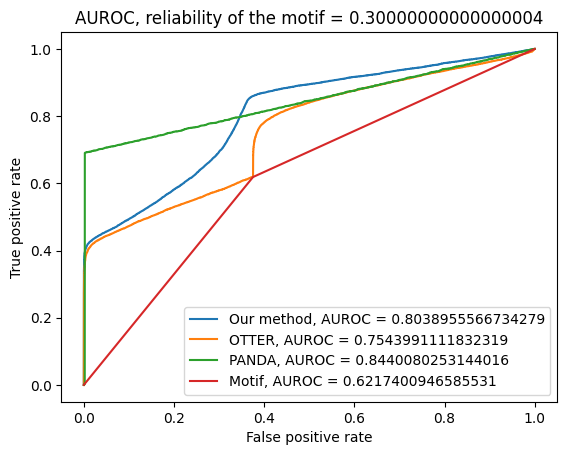

TP = 11357
FP = 980
TN = 698
FN = 5090
0.6651034482758621
Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.04 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt               0            1            2            3            4   \
0    4602.889160  4596.156674  4591.741453  4597.514013  4597.550826   
1    4610.837994  4592.331172  4601.347318  4609.854303  4607.573716   
2    4584.282964  4587.069798  4595.997391  4585.596919  4590.835314   
3    4618.484667  4626.503935  4617.576079  4612.224755  4612.933376   
4    4603.719725  4602.607840  4596.164662  4609.409528  4614.988570   
..           ...          ...          ...          ...          ...   
495  4623.512175  4624.691052  4612.657810  4615.283013  4614.356984   
496  4611.646067  4615.235572  4616.050120  4603.860738  4607.8

step: 117, hamming: 0.05291648240517709
step: 118, hamming: 0.043325074981373154
step: 119, hamming: 0.03547210151723831
step: 120, hamming: 0.029042489194601076
step: 121, hamming: 0.023778264256935917
step: 122, hamming: 0.01946820550359809
step: 123, hamming: 0.015939372178010062
step: 124, hamming: 0.01305016701609909
step: 125, hamming: 0.010684655930070322
step: 126, hamming: 0.008747917258411996
step: 127, hamming: 0.0071622336516754
step: 128, hamming: 0.005863973868520348
step: 129, hamming: 0.004801039953347994
step: 130, hamming: 0.00393077682992816
step: 131, hamming: 0.0032182609544910957
step: 132, hamming: 0.002634898814528831
step: 133, hamming: 0.0021572797882200684
step: 134, hamming: 0.0017662365283380495
step: 135, hamming: 0.0014460760129370027
step: 136, hamming: 0.0011839496829708805
step: 137, hamming: 0.000969338114995975
Running panda took: 3.18 seconds!
Saving PANDA network to tmp/panda_res.txt ...
                    Use old_compatible=False to save the pand

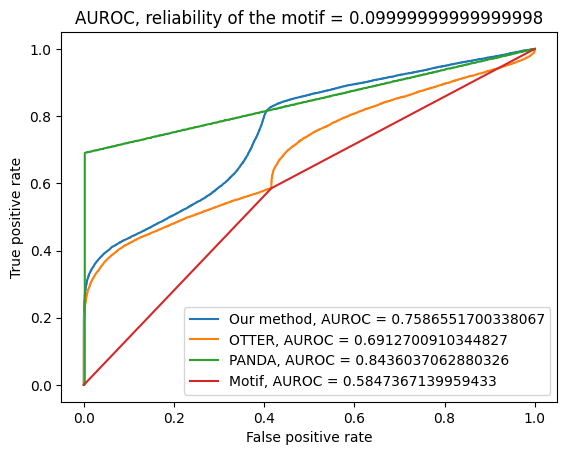

In [189]:
shuffling = [0.01, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]

scores = []
for shuffle in shuffling :
    scores.append(simulation(shuffling = shuffle))
    
giraffe.utils.star_plot(list(map(list, zip(*scores))), [str(round(1 - shuffle, 2)) for shuffle in shuffling], ["Our method", "OTTER", "PANDA", "Motif"])

We observe how GIRAFFE is the best method across multiple noise setting. Moreover it is the most robust one: PANDA outperforms it in the case where the motif is non-reliable, but it performs significantly worse in the case the motif is reliable. OTTER has similar performance for a reliable motif, but it gets worse as the motif gradually becomes more corrupted. 

## 3. Recovering ground-truth from projections

We create a new synthetic dataset. The dimensionality are picked to be coherent with the typical biological setting. 

In [63]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

Similarly as before, we need to simulate the ground-truth regulation matrix R. We generate a sparse matrix, where non-zero entries are uniformly sampled in (0, 1). 

In [81]:
def generate_regulation(g, tf) :
    sparsity = 0.2
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    R = scipy.sparse.random(g, tf, sparsity, random_state = rng, data_rvs = rvs).A
    return R

The motif is computed from the true regulation matrix by corrupting it with random uniform noise. 

In [65]:
def generate_motif(r):
    return r + np.random.normal(0, .2, (r.shape[0], r.shape[1]))

We decide that two proteins interact if they co-regulate "many" genes. To pick a proper threshold value, we plot the distribution of the number of co-regulated genes. 

(0.0, 510.0)

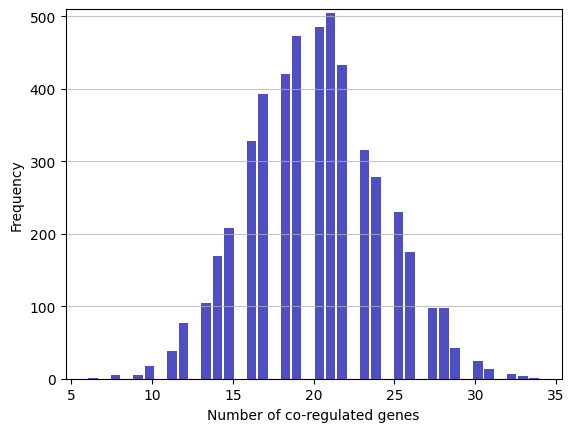

In [66]:
R = generate_regulation(G, TF)

cooperation = []
R[R != 0] = 1
for i in range(TF):
    for j in range(i + 1, TF):
        cooperation.append(R[:, i].dot(R[:, j]))

"The following lines or code are taken from https://realpython.com/python-histograms/ [Accessed on Jan. 13th 2023]"
s, bins, patches = plt.hist(x = cooperation, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Number of co-regulated genes')
plt.ylabel('Frequency')
maxfreq = s.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

We want a sparse PPI, so we heuristically pick 25 as threshold value (larger than the mean, but small enough to recover enough information). We now construct the PPI network. 

In [67]:
def generate_ppi(R):
    ppi = np.zeros((R.shape[1], R.shape[1]))
    R[R != 0] = 1
    for i in range(R.shape[1]):
        for j in range(R.shape[1]):
            if i == j :
                ppi[i, j] = 1 # By definition
            else :
                if R[:, i].dot(R[:, j]) >= 25:
                    ppi[i, j] = 1
    return ppi

Gene expressioned is sampled from a multi-normal distribution with mean zero and the same covariance as the regulation matrix. 

In [68]:
def generate_expression(C) :
    return np.random.multivariate_normal([0 for i in range(G)], C.T, n).T

Now we have generators for all required data: a ground-truth regulation matrix, a corrupter motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [79]:
def simulation() :
    R = generate_regulation(G, TF)
    ppi = generate_ppi(R.copy())
    motif = generate_motif(R)
    expression = generate_expression(R.dot(R.T))

    otter_regulation = otter(motif.T, ppi, np.corrcoef(motif))
    giraffe_oracle_regulation = giraffe.Giraffe(expression, motif, ppi, lam = [0.000001, 5, 50, 1, 1]).get_regulation()
    giraffe_agnostic_regulation = giraffe.Giraffe(expression, motif, ppi).get_regulation()
    hit = 0
    tot = 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i, j] > 0:
                tot += 1
                if giraffe_agnostic_regulation[i, j] > 0:
                    hit += 1
            if R[i, j] < 0:
                tot += 1
                if giraffe_agnostic_regulation[i, j] < 0:
                    hit += 1
    print(str(hit) + " " + str(tot))
    motif[motif >= np.quantile(motif, .6)] = 1 # PANDA requires a binary motif
    motif[motif != 1] = 0
    panda_regulation = giraffe.utils.compute_panda_locally(expression, motif, ppi)
    giraffe.utils.plot_auroc(
        R, 
        [otter_regulation.T, giraffe_oracle_regulation, giraffe_agnostic_regulation,panda_regulation, motif], 
        ["OTTER", "GIRAFFE (custom weights)", "GIRAFFE (learned weights)", "PANDA", "Motif"]
    )

9147 10000
Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 1676
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt            0         1         2         3         4         5         6   \
0   -3.384139 -0.239271 -0.602292 -4.584094  1.528830  4.805970 -1.622262   
1    2.233234  3.311422  2.218281  0.796614 -0.590712 -1.098253  1.339961   
2    1.309765  1.892338 -4.845616  1.211180 -2.190150  0.606410 -3.462348   
3    1.006124 -3.169939  2.088879  5.061582 -0.201494 -4.053278 -2.860526   
4   -0.892900  0.976236 -7.395540  1.473975 -1.342537 -1.234309 -3.059997   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.908976 -0.864340 -1.937995 -0.743871 -0.473887 -2.432047 -0.730278   
496 -0.407791 -0.758854  2.640542 -0.258860 -0.548204  1.101119 -0.59

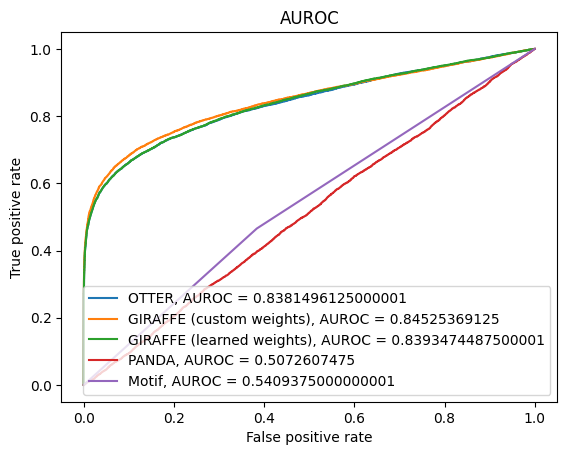

In [82]:
simulation()

We observe that GIRAFFE performs better than the other baselines. Note how GIRAFFE optionally accepts custom weights: this can be tuned (using proper statistical practices) and guide the optimization algorithm to focus on the reconstruction loss, the coherence with the PPI, or the coherence with the co-expression network. If no custom weights are provided, GIRAFFE assigns weights internally using a multi-task learning algorithm [3]. 

# Adjusting

In [2]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('data/sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

def generate_tfa(ppi, n):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(0, 10, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(0, 10, n)
            
    return TFA #  Generated matrix

def generate_regulation(g, tf, ppi) :
    sparsity = .8
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

def generate_motif(R):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * .9)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    return motif

def compute_expression(R, TFA, confounder) :
    return R.dot(np.abs(TFA)) + np.array([confounder for i in range(R.shape[0])])

In [3]:
import torch
def simulation(n = 50):

    tf = 100
    g = 500
    
    confounder = np.random.uniform(0, 1, n)
    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA, confounder)
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), 'cf', '~cf')
    motif = generate_motif(R)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R.copy(), [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Hidden variable")
    
    gene_expression = R.dot(np.abs(TFA) + np.array([confounder for i in range(TFA.shape[0])])) + np.array([confounder for i in range(R.shape[0])])
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), pd.DataFrame(confounder, columns = ['cf']), '~ cf')
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R, [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Confounder")
    
    gene_expression = R.dot(np.abs(TFA) + np.array([confounder for i in range(TFA.shape[0])])) #+ np.array([confounder for i in range(R.shape[0])])
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), pd.DataFrame(confounder, columns = ['cf']), '~ cf')
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R, [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Causal sufficiency")

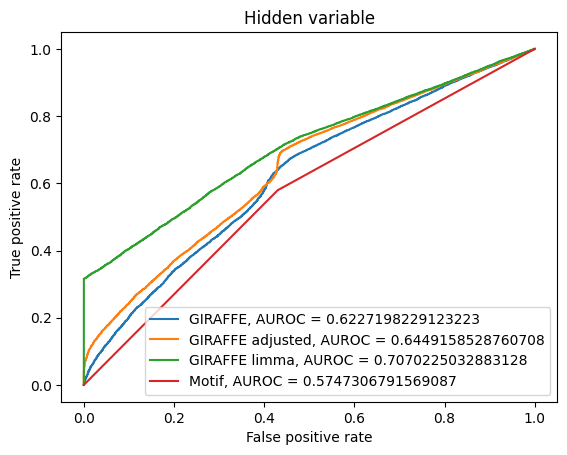

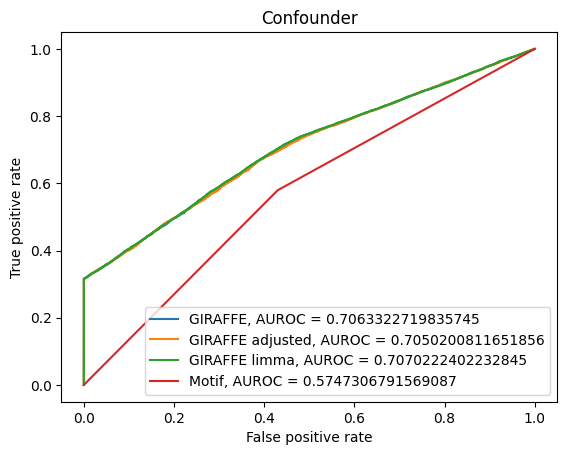

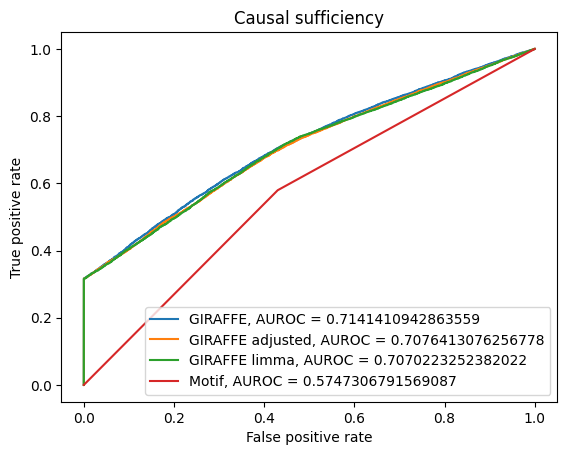

In [4]:
simulation()

# Old

In [ ]:
def single_sample_simulation(n = 50, shuffling = 0.2):
    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA)
    motif = generate_motif(R, shuffling)
    
    model = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001)
    R_giraffe = model.get_regulation()
    TFA_giraffe = model.get_tfa()
    scores = []
    for i in range(n):
        R_sample = R.dot(np.diag(TFA[:, i]))
        R_est = R_giraffe.dot(np.diag(TFA_giraffe[:, i]))
        score, _, _ = giraffe.evaluate_regulation_auroc(R_sample.flatten(), R_est.flatten())
        scores.append(score)
    print(np.mean(scores))

In [11]:
# USING AGGREGATE NETWORK
shuffling = [0.01, 0.3, 0.5, 0.5, 0.6, 0.7, 0.9]

for shuffle in shuffling :
    single_sample_simulation(shuffling = shuffle)

0.9905018384208824
0.8452284723200003
0.7753434982399999
0.7744203050666668
0.7433835639466666
0.7158037247999998
0.6695448584533333


In [13]:
# USING OUR METHOD
shuffling = [0.01, 0.3, 0.5, 0.5, 0.6, 0.7, 0.9]

for shuffle in shuffling :
    single_sample_simulation(shuffling = shuffle)

0.9904010840063998
0.8495831056042665
0.7931819761664001
0.7960182637909334
0.7679466213034669
0.7478571230549332
0.7059166234965332


In [29]:
shuffling = [0.01, 0.3, 0.5, 0.5, 0.6, 0.7, 0.9]

for shuffle in shuffling :
    single_sample_simulation(shuffling = shuffle)

0.9682300171946667
0.8457318803797332
0.7993095107925332
0.7980851047082668
0.7819060210005333
0.7671523275093333
0.7458993214122666


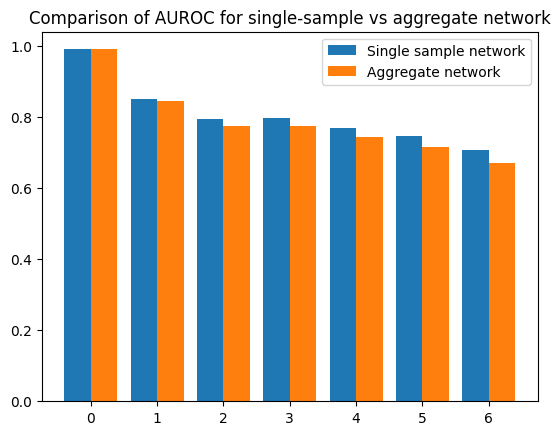

In [20]:
x = np.arange(7)
y1 = [0.9904010840063998, 0.8495831056042665, 0.7931819761664001, .7960182637909334, 0.7679466213034669, 0.7478571230549332, 0.7059166234965332]
y2 = [0.9905018384208824, 0.8452284723200003, 0.7753434982399999, 0.7744203050666668, 0.7433835639466666, 0.7158037247999998, 0.6695448584533333]
plt.bar(x-0.2, y1, .40, label = 'Single sample network')
plt.bar(x+0.2, y2, .40, label = 'Aggregate network')
plt.title("Comparison of AUROC for single-sample vs aggregate network")
plt.legend()

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.

[3] Lee J.H, Kim C. S. Multi-loss rebalancing algorithm for monocular depth estimation. In European Conference on Computer Vision, pages 785–801. Springer, 2020.